In [1]:

import numpy as np
import sys
import cv2
from hdr_processing.hdr_processing import *
import os
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from PIL import Image, ExifTags


In [2]:
folder = "./master_room_photos/"

img_list = [cv2.imread(fn) for fn in [f"{folder}20.jpg", f"{folder}50.jpg", f"{folder}125.jpg"]]#, f"{folder}/180.jpg"]]
img_list_pil = [Image.open(fn) for fn in [f"{folder}20.jpg", f"{folder}50.jpg", f"{folder}125.jpg"]]#, f"{folder}/180.jpg"]]

exif_list = []
for img in img_list_pil:
    exif = { ExifTags.TAGS[k]: v  for k, v in img._getexif().items()  if k in ExifTags.TAGS }
    exif_list.append(exif)
print(exif_list)

[{'ImageWidth': 4000, 'ImageLength': 3000, 'GPSInfo': {1: 'N', 2: (46.0, 0.0, 42.3684), 3: 'E', 4: (8.0, 57.0, 41.150159), 5: 0, 6: 334.0}, 'ResolutionUnit': 2, 'ExifOffset': 240, 'Make': 'samsung', 'Model': 'Galaxy S23+', 'Software': 'S916BXXS3AWHR', 'Orientation': 6, 'DateTime': '2023:10:06 19:18:43', 'YCbCrPositioning': 1, 'XResolution': 72.0, 'YResolution': 72.0, 'ExifVersion': b'0220', 'ShutterSpeedValue': 0.05, 'ApertureValue': 1.69, 'DateTimeOriginal': '2023:10:06 19:18:43', 'DateTimeDigitized': '2023:10:06 19:18:43', 'BrightnessValue': 2.53, 'ExposureBiasValue': 0.0, 'MaxApertureValue': 1.69, 'MeteringMode': 2, 'Flash': 0, 'FocalLength': 5.4, 'ColorSpace': 65535, 'ExifImageWidth': 4000, 'DigitalZoomRatio': 1.0, 'FocalLengthIn35mmFilm': 23, 'SceneCaptureType': 0, 'OffsetTime': '+02:00', 'OffsetTimeOriginal': '+02:00', 'SubsecTime': '254', 'SubsecTimeOriginal': '254', 'SubsecTimeDigitized': '254', 'ExifImageHeight': 3000, 'ExposureTime': 0.05, 'FNumber': 1.8, 'ImageUniqueID': 'P1

Images aligned


([], [])

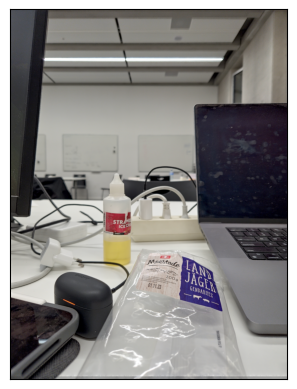

In [3]:
alignment_8bit_list = np.array(align_images(img_list=img_list.copy()))
resFusion_8bit = exposure_fusion(img_list=alignment_8bit_list)
rgb = cv2.cvtColor(resFusion_8bit.copy(), cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.xticks([])
plt.yticks([])

In [4]:
if not os.path.exists("./out_images/fusion/"):
    os.mkdir("./out_images/fusion")
cv2.imwrite("./out_images/fusion/fusion_master_room.jpg", resFusion_8bit)

True

In [5]:
alignment_8bit_list = np.array(align_images(img_list=img_list.copy()))
print(alignment_8bit_list.shape)

Images aligned
(3, 4000, 3000, 3)


exposure times: [0.05  0.02  0.008]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Calibrated


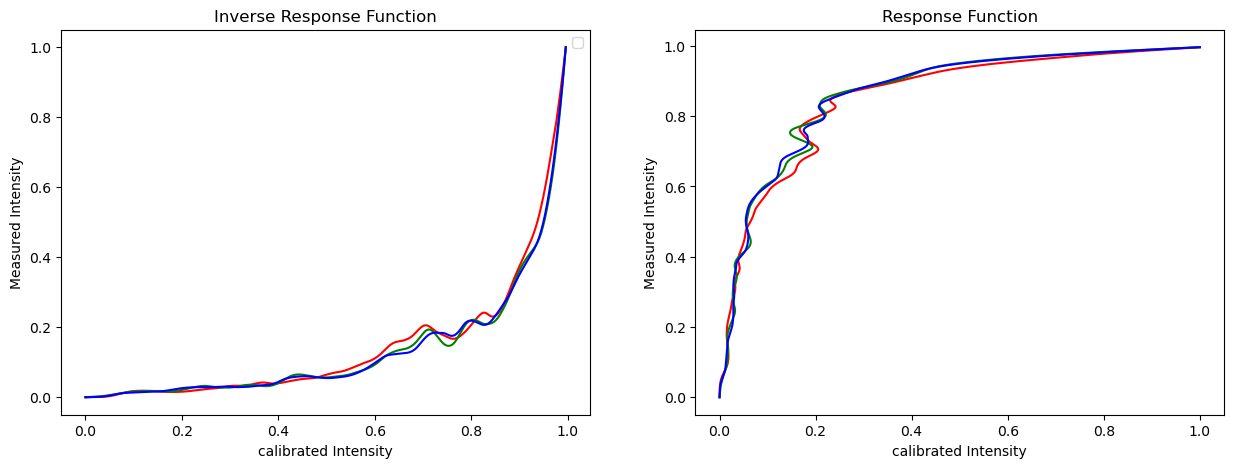

In [6]:
ev_values = [-2, 2, 0]
aperture = [1.6, 1.6, 1.6]
ISO = 100.0

exposure_times = np.array([i['ExposureTime'] for i in exif_list], dtype=np.float32)
print(f"exposure times: {exposure_times}")
#exposure_times = np.array([ap ** 2 / (2 ** (ev - math.log2(100.0 / ISO))) for ev, ap in zip(ev_values, aperture)], dtype=np.float32)
response = calibrate_debevec(img_list=img_list, exposure_times=exposure_times.copy())

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel("calibrated Intensity")
ax.set_ylabel("Measured Intensity")
ax.set_title("Inverse Response Function")
for i, color in zip(range(3), ["blue","green", "red", ]):
    new_response = MinMaxScaler().fit_transform(response[:, 0, i].reshape(-1, 1))
    ax.plot(np.arange(0, 1, 1/256), new_response,  c=color)
    
plt.legend()
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel("calibrated Intensity")
ax.set_ylabel("Measured Intensity")
ax.set_title("Response Function")
for i, color in zip(range(3), ["red", "green", "blue"]):
    new_response = MinMaxScaler().fit_transform(response[:, 0, i].reshape(-1, 1))
    ax.plot(new_response,np.arange(0, 1, 1/256) ,  c=color)

In [7]:
hdr_merge = merge_debevec(img_list=alignment_8bit_list, exposure_times=exposure_times.copy(), response=response)

Merged


[ WARN:0@4.243] global matrix_expressions.cpp:1334 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


0.55397433


([], [])

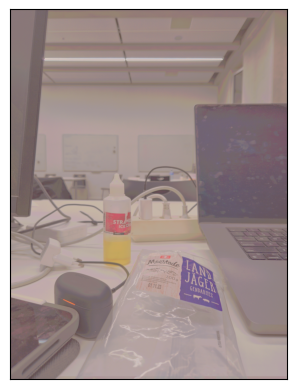

In [8]:
tonemap = cv2.createTonemapReinhard(gamma=2.2)

hdr_merge_8bit = tonemap.process(hdr_merge.copy())
res_debevec_8bit = np.clip(hdr_merge_8bit*255, 0, 255).astype('uint8')
res_debevec_16bit = np.clip(hdr_merge_8bit*511, 0, 511).astype('uint16')
cv2.imwrite("./out_images/debevec/vlad_debevec_16bit.jpg", res_debevec_16bit)
cv2.imwrite("./out_images/debevec/vlad_debevec_8bit.jpg", res_debevec_8bit)
print(np.mean(hdr_merge_8bit))
rgb = cv2.cvtColor(res_debevec_8bit.copy(), cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.xticks([])
plt.yticks([])